## Notebook to scan PD risk and QTL results for colocalization

In [1]:
!date

Tue Aug 17 17:36:36 EDT 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import concurrent.futures
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
# parameters
cohort = 'foundin'

In [4]:
# naming

# directories
home_dir = '/home/gibbsr'
wrk_dir = f'{home_dir}/{cohort}/caqtl'
tensorqtl_dir = f'{wrk_dir}/tensorqtl'
results_dir = f'{wrk_dir}/results'
gwas_dir = f'{wrk_dir}/public/'

# input files
qtl_results_file = f'{results_dir}/{cohort}.cis.csv'
meta5_st2_clean_file = f'{gwas_dir}/pd.table_s2.clean.txt'
meta5_stats_file = f'{gwas_dir}/pdmeta_sumstats_hg38.h5'

# output files

# constant values
autosomes = [str(x) for x in list(range(1,23))]
alpha_value = 0.05
cpu_count = len(os.sched_getaffinity(0))

#### analysis functions

In [5]:
def mixed_model(formula, df, group_name):
    model = sm.MixedLM.from_formula(formula, df, groups=df[group_name])
    result = model.fit()
    return result

def reg_model(y, x):
    Xb = sm.add_constant(x)
    reg_model = sm.OLS(y, Xb).fit()
    return reg_model

def regress_scores_keep(this_df, mixed=False, verbose=False):
    # run the regression, if specified mixed effects model with day as random effect
    this_formula = 'gwas_score_abs ~ qtl_score_abs'
    try:
        if mixed:
            grouping = 'day'
            result = mixed_model(this_formula, this_df, grouping)
        else:
            result = smf.ols(this_formula, data=this_df).fit()            
        if verbose:
            print(result.summary())
        term = 'qtl_score_abs'
#         print(['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
#         print(result.params[term], result.bse[term], 
#               result.params.shape[0], result.pvalues[term])    
        ret_list = [result.params[term], result.bse[term], 
                    result.params.shape[0], result.pvalues[term]]
    except IndexError:    
        ret_list = [0, 0, 0, 1]
    return ret_list

def create_merged_df_to_regress(qtl_df, pheno_id, gwas_df):
    pheno_df = qtl_df.loc[qtl_df['phenotype_id'] == pheno_id]
    merged_df = pheno_df.merge(gwas_df, how='inner', 
                               left_on='variant_id', right_on='SNP')
    # will test regression on absolute score instead of say p-value
    merged_df['day'] =  merged_df['day'].astype(object)
    merged_df['gwas_score_abs'] = np.abs(merged_df['b']/merged_df['se'])
    merged_df['qtl_score_abs'] = np.abs(merged_df['slope']/merged_df['slope_se'])

    # for regression will only consider variants that are nominally
    # significant in gwas or qtl
    df_to_return = merged_df.loc[(merged_df['pval_nominal'] < alpha_value) | 
                                 (merged_df['p'] < alpha_value)]
    #     print(pheno_df.shape, merged_df.shape, alpha_df.shape)
    return df_to_return

def load_chrom_result(chrom, days, in_dir, cohort):
    # have to do pass to find all phenos to possible capture
    df_to_return = None
    phenos_oi = []
    for day in days:
        chrom_file = f'{in_dir}/{cohort}.{day}.*.cis_qtl_pairs.chr{chrom}.parquet'
        chrom_qtl_df = dd.read_parquet(chrom_file).compute()
        oi_chrom_qtl_df = chrom_qtl_df.loc[chrom_qtl_df['pval_nominal'] < max_pvalue]
        oi_results = oi_chrom_qtl_df.loc[oi_chrom_qtl_df['variant_id'].isin(variants_oi_df['SNP'])]
        phenos_oi = phenos_oi + list(oi_results['phenotype_id'].unique())

    # do pass to keep results that belong those phenos
    for day in days:
        chrom_file = f'{in_dir}/{cohort}.{day}.*.cis_qtl_pairs.chr{chrom}.parquet'
        chrom_qtl_df = dd.read_parquet(chrom_file).compute()
        possible_results_oi = chrom_qtl_df.loc[chrom_qtl_df['phenotype_id'].isin(phenos_oi)].copy()
        possible_results_oi['day'] = day
        df_to_return = pd.concat([df_to_return, possible_results_oi])
    return phenos_oi, df_to_return

def process_regression_check(chrom, days, in_dir, cohort, gwas_df):
    results_to_keep = None
    phenos_oi, results_to_test = load_chrom_result(chrom, days, in_dir, cohort)
    print(f'chr {chrom} shape {results_to_test.shape}')
    # display(results_to_test.sample(5))

    # test the GWAS~qtl regression for possible significance
    for phenotype_id in phenos_oi:
        alpha_df = create_merged_df_to_regress(results_to_test, phenotype_id, gwas_df)
        
        # ['coef', 'stderr', 'term_cnt', 'p-value']
        if len(set(days)) > 1:
            ret_vals = regress_scores_keep(alpha_df, mixed=True)
        else:
            ret_vals = regress_scores_keep(alpha_df)
        # must have postive coefficient and nomically significant p-value
        if ret_vals[0] > 0 and ret_vals[3] < alpha_value:
            results_to_keep = pd.concat([results_to_keep, alpha_df])
    return results_to_keep

#### load the risk variants of interest

In [6]:
%%time
variants_oi_df = pd.read_csv(meta5_st2_clean_file, sep='\t')
print(variants_oi_df.shape)
variants_oi_df.head()

(91, 12)
CPU times: user 4.12 ms, sys: 15 µs, total: 4.14 ms
Wall time: 3.68 ms


,SNP,CHR,BP,Nearest_Gene,QTL_Nominated_Gene,Effect_allele,Other_allele,EAF,Beta_all_studies,SE_all_studies,P_all_studies,P_COJO_all_studies
0,rs114138760,1,154898185,PMVK,NaN,c,g,0.0112,0.2812,0.0478,4.190000e-09,1.090000e-08
1,rs35749011,1,155135036,KRTCAP2,EFNA3,a,g,0.0169,0.6068,0.0342,1.720000e-70,3.820000e-77
2,rs76763715,1,155205634,GBAP1,NaN,t,c,0.9953,-0.7467,0.0765,1.590000e-22,9.900000e-23
3,rs6658353,1,161469054,FCGR2A,FCGR2A,c,g,0.5011,0.0650,0.0094,6.100000e-12,4.690000e-12
4,rs11578699,1,171719769,VAMP4,VAMP4,t,c,0.1949,-0.0704,0.0120,4.470000e-09,4.450000e-09


#### load the full gwas summary stats

In [7]:
%%time
gwas_stats_df = pd.read_hdf(meta5_stats_file)
print(gwas_stats_df.shape)
display(gwas_stats_df.sample(5))

(7769022, 11)


,SNP,A1,A2,freq,b,se,p,N,chr,position,id
602008,rs7928155,A,G,0.4300,-0.0183,0.0096,0.05571,1474097,chr11,41190552,rs7928155
1095856,rs117668804,T,C,0.0440,-0.0270,0.0662,0.68320,468692,chr12,80382099,rs117668804
632201,rs78905015,A,G,0.9394,0.0069,0.0215,0.74720,1474097,chr11,50523305,rs78905015
2239,rs2862448,T,C,0.2627,-0.0171,0.0115,0.13610,1461852,chr10,98844181,rs2862448
1077114,rs58870646,A,G,0.9898,0.0586,0.0562,0.29700,1002885,chr12,74060790,rs58870646


CPU times: user 21.3 s, sys: 1.06 s, total: 22.4 s
Wall time: 22.3 s


#### load the QTL

In [8]:
qtl_df = pd.read_csv(qtl_results_file)
print(qtl_df.shape)
number_features = len(qtl_df['phenotype_id'].unique())
print(f'qtl for {number_features} features')
qtl_df.head()

(2642, 15)
qtl for 746 features


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,day,log10_pvalue,score,score_abs,is_sig
0,chr11_51374436_51374957,rs11537292,-732164,0.117021,21,22,2.523234e-06,0.216202,0.043075,chr11_51374436_51374957:rs11537292,da0,5.598042,5.019248,5.019248,1
1,chr11_19509193_19509832,rs2129538,284,0.335106,51,63,6.349979e-01,0.007840,0.016462,chr11_19509193_19509832:rs2129538,da0,0.197228,0.476289,0.476289,0
2,chr11_130611832_130612822,rs61915783,-4400,0.430851,60,81,9.002045e-01,-0.002054,0.016331,chr11_130611832_130612822:rs61915783,da0,0.045659,-0.125750,0.125750,0
3,chr11_83640004_83642261,rs12275022,1553,0.260638,43,49,7.462559e-01,-0.005984,0.018437,chr11_83640004_83642261:rs12275022,da0,0.127112,-0.324553,0.324553,0
4,chr11_107293765_107294592,rs2355840,-6514,0.234043,35,44,4.846152e-15,0.129220,0.013792,chr11_107293765_107294592:rs2355840,da0,14.314603,9.369365,9.369365,1


#### which day are present in the results (typically will be all in cohort)

In [9]:
days = sorted(list(qtl_df['day'].unique()))
print(days)

['da0', 'da25', 'da65']


#### grab the max pval_nominal and max pval_beta

In [10]:
max_pvalue = qtl_df[qtl_df['is_sig'] == 1]['pval_nominal'].max()
print(f'max p-value: {max_pvalue}')
max_pvalue = 0.00001
print(f'hardcoded max p-value: {max_pvalue}')

max p-value: 5.167897292332124e-05
hardcoded max p-value: 1e-05


#### see if any of the top significant results happen to be risk independent variants

In [11]:
def check_qtls_for_variants(qtl_df, variants_df):
    qtl_variants_oi_df = qtl_df.loc[qtl_df['variant_id'].isin(variants_df['SNP'])]
    print(qtl_variants_oi_df.shape)
    this_cnt = len(qtl_variants_oi_df['variant_id'].unique())
    print(f'variants {this_cnt}')
    print(qtl_variants_oi_df['variant_id'].unique())
    oi_features = qtl_variants_oi_df['phenotype_id'].unique()
    print(f'features {len(oi_features)}')
    print(oi_features)
    return qtl_variants_oi_df

In [12]:
risk_features = check_qtls_for_variants(qtl_df, variants_oi_df)
if len(risk_features) > 0:
    display(risk_features.head())

(0, 15)
variants 0
[]
features 0
[]


#### now load rest of results and see if risk index variants are qtl

In [13]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [14]:
%%time

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor() as ppe:
    for chrom in autosomes:
#         fs_list.append(ppe.submit(process_regression_check, chrom, ['da65'], 
#                                   tensorqtl_dir, cohort, gwas_stats_df))
        fs_list.append(ppe.submit(process_regression_check, chrom, days, 
                                  tensorqtl_dir, cohort, gwas_stats_df))

chr 5 shape (0, 10)
chr 9 shape (0, 10)
chr 3 shape (0, 10)
chr 1 shape (16869, 10)
chr 13 shape (0, 10)
chr 4 shape (0, 10)
chr 15 shape (0, 10)
chr 8 shape (20166, 10)
chr 7 shape (0, 10)
chr 14 shape (0, 10)
chr 2 shape (23469, 10)
chr 10 shape (0, 10)
chr 6 shape (0, 10)
chr 16 shape (18219, 10)
chr 11 shape (0, 10)
chr 12 shape (0, 10)
chr 21 shape (0, 10)
chr 17 shape (157140, 10)
chr 18 shape (0, 10)
chr 19 shape (0, 10)
chr 22 shape (0, 10)
chr 20 shape (0, 10)
CPU times: user 3min 8s, sys: 18 s, total: 3min 26s
Wall time: 5min 10s


In [15]:
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result())

# flatten the list
results_to_keep = pd.concat([item for item in lm_results])

In [16]:
print(results_to_keep.shape)
display(results_to_keep.sample(5))

(65931, 23)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,day,...,freq,b,se,p,N,chr,position,id,gwas_score_abs,qtl_score_abs
7417,chr1_205849678_205850531,rs11809273,-109294,0.032609,6,6,0.456183,0.039822,0.053211,da25,...,0.9829,0.0854,0.0393,2.980000e-02,1474097,chr1,205740384,rs11809273,2.173028,0.748379
135,chr17_46253771_46254484,rs36107645,-978496,0.250000,40,47,0.761844,-0.006093,0.020046,da0,...,0.8047,-0.0369,0.0118,1.751000e-03,1474097,chr17,45275275,rs36107645,3.127119,0.303961
1431,chr17_46286493_46287348,rs35908989,-369838,0.239362,41,45,0.010977,-0.052275,0.020136,da0,...,0.7498,-0.0615,0.0121,3.368000e-07,1016923,chr17,45916655,rs35908989,5.082645,2.596055
4833,chr1_205849678_205850531,rs7537336,-414120,0.271277,43,51,0.010917,-0.048681,0.018737,da0,...,0.2206,0.0141,0.0122,2.487000e-01,1460059,chr1,205435558,rs7537336,1.155738,2.598087
1547,chr17_46224432_46226127,rs71375321,-398883,0.039326,7,7,0.509480,-0.028466,0.042975,da65,...,0.0436,0.0502,0.0232,3.069000e-02,1471960,chr17,45825549,rs71375321,2.163793,0.662378


In [17]:
print(len(results_to_keep['phenotype_id'].unique()))
print(results_to_keep['phenotype_id'].unique())

12
['chr2_95299794_95302609' 'chr2_101974474_101975378'
 'chr17_45518784_45519997' 'chr17_46286493_46287348'
 'chr17_46253771_46254484' 'chr17_45512153_45513143'
 'chr17_45515245_45518203' 'chr17_45600157_45602549'
 'chr17_46224432_46226127' 'chr17_45500945_45502221'
 'chr17_46558329_46559964' 'chr1_205849678_205850531']


In [18]:
import random
phenotype_id = random.choice(results_to_keep['phenotype_id'].unique())
print(phenotype_id)

chr17_46286493_46287348


In [19]:
temp = results_to_keep.loc[results_to_keep['phenotype_id'] == phenotype_id]
print(temp.shape)
display(temp.head())

(3087, 23)


,phenotype_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,day,...,freq,b,se,p,N,chr,position,id,gwas_score_abs,qtl_score_abs
9,chr17_46286493_46287348,rs11079503,-998770,0.170213,29,32,0.022638,-0.050645,0.021844,da0,...,0.1277,0.0338,0.0140,0.01601,1474097,chr17,45287723,rs11079503,2.414286,2.318497
10,chr17_46286493_46287348,rs11079503,-998770,0.163043,28,30,0.718478,-0.008869,0.024527,da25,...,0.1277,0.0338,0.0140,0.01601,1474097,chr17,45287723,rs11079503,2.414286,0.361627
11,chr17_46286493_46287348,rs11079503,-998770,0.174157,28,31,0.374420,-0.019818,0.022197,da65,...,0.1277,0.0338,0.0140,0.01601,1474097,chr17,45287723,rs11079503,2.414286,0.892813
15,chr17_46286493_46287348,rs11574815,-998467,0.170213,29,32,0.022638,-0.050645,0.021844,da0,...,0.1266,0.0344,0.0141,0.01473,1474097,chr17,45288026,rs11574815,2.439716,2.318497
16,chr17_46286493_46287348,rs11574815,-998467,0.163043,28,30,0.718478,-0.008869,0.024527,da25,...,0.1266,0.0344,0.0141,0.01473,1474097,chr17,45288026,rs11574815,2.439716,0.361627


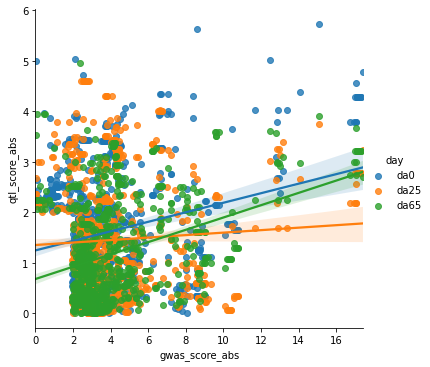

In [20]:
sns.lmplot(x='gwas_score_abs', y='qtl_score_abs', hue='day', data=temp)

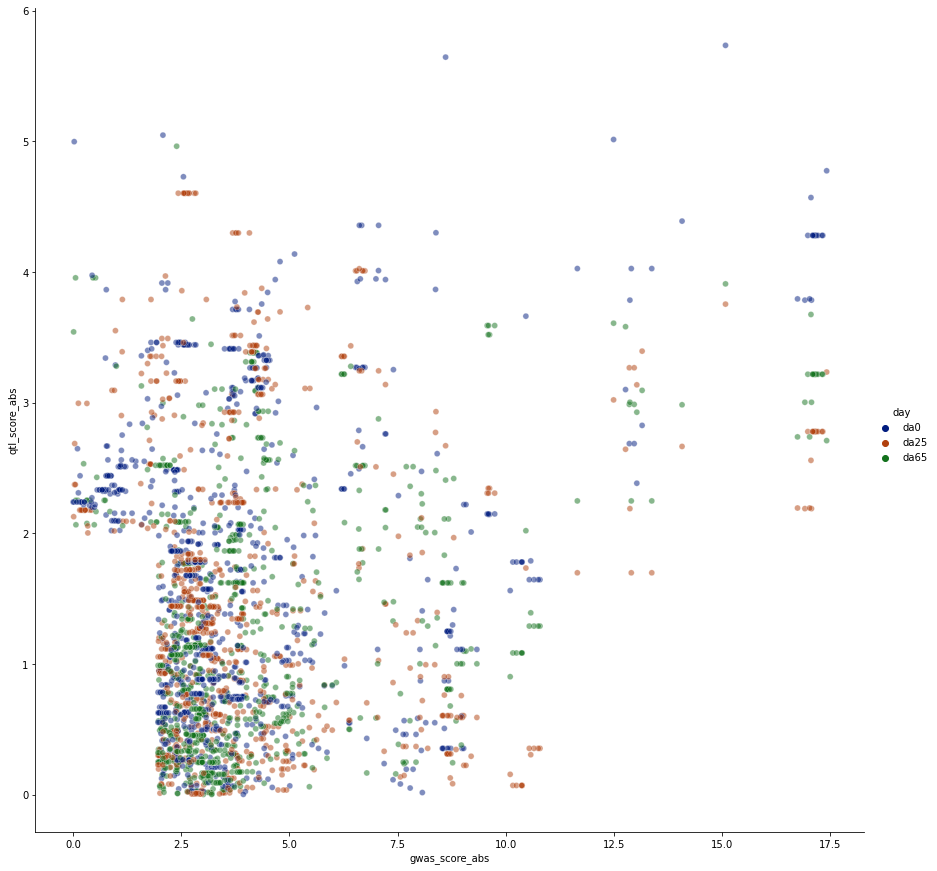

In [21]:
sns.relplot(x='gwas_score_abs', 
            y='qtl_score_abs', 
            hue='day', alpha=.5, palette="dark", 
            height=12, data=temp) 

In [22]:
this_formula = 'gwas_score_abs ~ qtl_score_abs'
grouping = 'day'
result = mixed_model(this_formula, temp, grouping)
print(result.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: gwas_score_abs
No. Observations: 3087    Method:             REML          
No. Groups:       3       Scale:              7.1347        
Min. group size:  991     Log-Likelihood:     -7418.6323    
Max. group size:  1079    Converged:          Yes           
Mean group size:  1029.0                                    
-------------------------------------------------------------
               Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept      3.164     0.157  20.149  0.000   2.856   3.472
qtl_score_abs  0.557     0.047  11.953  0.000   0.466   0.648
Group Var      0.054     0.023                               



In [23]:
term = 'qtl_score_abs'
print(['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(result.params[term], result.bse[term], 
      result.params.shape[0], result.pvalues[term])

['feature', 'coef', 'stderr', 'term_cnt', 'p-value']
0.5571300600837142 0.04661194853214146 3 6.298896245429923e-33


In [24]:
this_formula = 'gwas_score_abs ~ qtl_score_abs'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:         gwas_score_abs   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     132.2
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           5.35e-30
Time:                        17:42:13   Log-Likelihood:                -7419.8
No. Observations:                3087   AIC:                         1.484e+04
Df Residuals:                    3085   BIC:                         1.486e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.1981      0.081     39.422

In [25]:
temp.columns

Index(['phenotype_id', 'variant_id', 'tss_distance', 'af', 'ma_samples',
       'ma_count', 'pval_nominal', 'slope', 'slope_se', 'day', 'SNP', 'A1',
       'A2', 'freq', 'b', 'se', 'p', 'N', 'chr', 'position', 'id',
       'gwas_score_abs', 'qtl_score_abs'],
      dtype='object')

In [26]:
this_formula = 'gwas_score_abs ~ qtl_score_abs + day'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:         gwas_score_abs   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     50.06
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           1.39e-31
Time:                        17:42:13   Log-Likelihood:                -7411.2
No. Observations:                3087   AIC:                         1.483e+04
Df Residuals:                    3083   BIC:                         1.485e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.9060      0.111     26.289

In [27]:
this_formula = 'gwas_score_abs ~ qtl_score_abs + day + qtl_score_abs * day'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:         gwas_score_abs   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     41.00
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           5.82e-41
Time:                        17:42:13   Log-Likelihood:                -7385.2
No. Observations:                3087   AIC:                         1.478e+04
Df Residuals:                    3081   BIC:                         1.482e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [28]:
temp['daynum'] = temp['day'].str.replace('da','').astype('int32')
this_formula = 'gwas_score_abs ~ qtl_score_abs + (1|daynum)'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:         gwas_score_abs   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     74.78
Date:                Tue, 17 Aug 2021   Prob (F-statistic):           1.93e-32
Time:                        17:42:13   Log-Likelihood:                -7411.5
No. Observations:                3087   AIC:                         1.483e+04
Df Residuals:                    3084   BIC:                         1.485e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.9300      0.104     28.108